<a href="https://colab.research.google.com/github/AMSUCF/DHProgramming/blob/main/BlueSky_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.24.3
!pip install atproto==0.0.61 --no-deps # Install without reinstalling dependencies
!pip install nltk==3.8.1 --no-deps # Install without reinstalling dependencies
!pip install pandas==1.5.3 --no-deps # Install without reinstalling dependencies
!pip install matplotlib==3.7.1 --no-deps # Install without reinstalling dependencies
!pip install seaborn==0.12.2 --no-deps # Install without reinstalling dependencies

from IPython import get_ipython
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2


In [4]:
!pip install atproto==0.0.61

from atproto import Client
import datetime
from google.colab import userdata

# Replace with your Bluesky username and password
BLUESKY_USERNAME = userdata.get('BLUESKY_USERNAME')
BLUESKY_PASSWORD = userdata.get('BLUESKY_APP_PASSWORD')

client = Client()
client.login(BLUESKY_USERNAME, BLUESKY_PASSWORD)

ProfileViewDetailed(did='did:plc:4ji772lj3mrupzidh47uh4za', handle='lucidbard.bsky.social', associated=ProfileAssociated(chat=None, feedgens=0, labeler=False, lists=0, starter_packs=0, py_type='app.bsky.actor.defs#profileAssociated'), avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:4ji772lj3mrupzidh47uh4za/bafkreidapxihe3tq3fvle7mcufsr6wd5huedtb6ebnlmtdz7u6vuv7b4wi@jpeg', banner=None, created_at='2023-08-18T17:37:32.415Z', description='He/him. Assoc. Professor of Games and Digital Media, UCF. Co-PI NSF Virtual Experience Research Accelerator. VR, AI, Interactive Narratives, Authoring Platforms. Co-author of Flash: Building the Interactive Web, Adventure Games: Playing the Outsider', display_name='John T. Murray', followers_count=504, follows_count=235, indexed_at='2024-11-16T14:05:05.518Z', joined_via_starter_pack=None, labels=[], pinned_post=None, posts_count=17, verification=None, viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, follo

In [5]:
def fetch_public_posts(client, query, limit=100):
    """Fetches public posts containing a query."""
    all_posts = []
    cursor = None

    while len(all_posts) < limit:
        # Create the params dictionary
        params = {
            'q': query,
            'limit': min(100, limit - len(all_posts)),  # Adjust limit
        }
        if cursor:
            params['cursor'] = cursor # Add cursor if available

        response = client.app.bsky.feed.search_posts(params)

        if not response.posts:
            break  # No more posts found

        for post in response.posts:
            all_posts.append({
                'text': post.record.text,
                'date': datetime.datetime.fromisoformat(post.record.created_at.replace('Z', '+00:00'))
            })

        cursor = response.cursor
        if not cursor:
            break  # No more pages

    return all_posts

# You can adjust the limit to fetch more posts
query = "AI"
posts = fetch_public_posts(client, query, limit=1000)

print(f"Found {len(posts)} public posts containing '{query}'.")

Found 1000 public posts containing 'AI'.


In [6]:
import json
import datetime

# Assuming 'posts' is the list of dictionaries containing the fetched posts

def save_posts_to_json(posts_list, filename="bluesky_posts.json"):
    """Saves a list of posts to a JSON file."""
    # Convert datetime objects to string format for JSON serialization
    serializable_posts = []
    for post in posts_list:
        serializable_post = post.copy() # Create a copy to avoid modifying the original list
        if isinstance(serializable_post.get('date'), datetime.datetime):
            serializable_post['date'] = serializable_post['date'].isoformat()
        serializable_posts.append(serializable_post)

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(serializable_posts, f, indent=4) # Use indent for readability

# Call the function to save the posts
save_posts_to_json(posts, filename="ai_bluesky_posts.json")

print(f"Saved {len(posts)} posts to ai_bluesky_posts.json")

Saved 1000 posts to ai_bluesky_posts.json


In [7]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except Exception: # Catch a more general exception
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def analyze_sentiment(posts_list):
    """Analyzes the sentiment of a list of posts."""
    sentiments = []
    for post in posts_list:
        sentiment_scores = sia.polarity_scores(post['text'])
        sentiments.append({
            'text': post['text'],
            'date': post['date'],
            'compound_sentiment': sentiment_scores['compound']
        })
    return sentiments

post_sentiments = analyze_sentiment(posts)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(post_sentiments)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...



Sentiment Distribution:
count    1000.000000
mean        0.050109
std         0.414991
min        -0.952200
25%         0.000000
50%         0.000000
75%         0.340000
max         0.961200
Name: compound_sentiment, dtype: float64

Sentiment Categories Count:
Neutral     427
Positive    332
Negative    241
Name: sentiment_category, dtype: int64


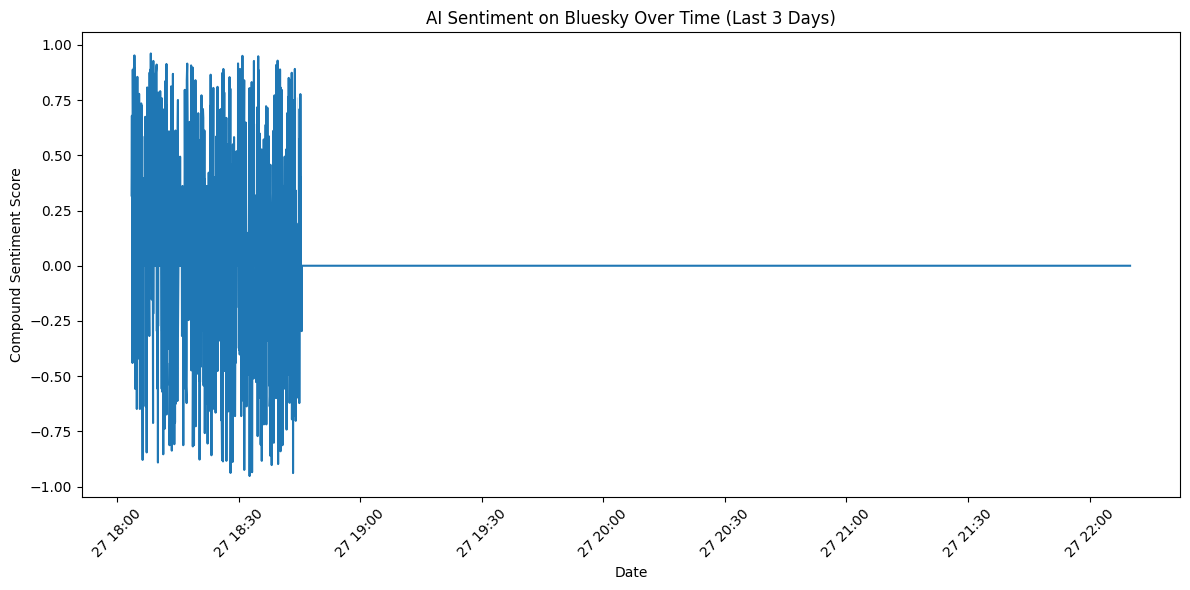

In [8]:
# Basic sentiment distribution
print("\nSentiment Distribution:")
print(df['compound_sentiment'].describe())

# You can categorize sentiment based on compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['compound_sentiment'].apply(categorize_sentiment)

print("\nSentiment Categories Count:")
print(df['sentiment_category'].value_counts())

# Visualize sentiment over time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='compound_sentiment')
plt.title('AI Sentiment on Bluesky Over Time (Last 3 Days)')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# You can also explore word frequencies, topics, etc., but those require more advanced NLP techniques.

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Download necessary NLTK data if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except Exception:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
# Initialize PorterStemmer directly
ps = PorterStemmer()

def preprocess_text(text):
    """Preprocesses text for topic modeling."""
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()]) # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words] # Remove stop words
    words = [ps.stem(word) for word in words] # Stemming
    return ' '.join(words)

# Apply preprocessing to the post text
df['processed_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # Limit features for manageability
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

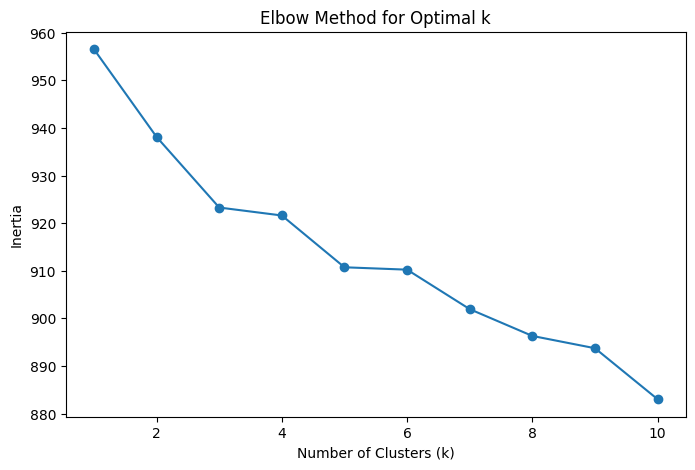

In [11]:
# Determine the optimal number of clusters (using Elbow Method)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10) # Set n_init explicitly
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Based on the Elbow Method, choose a suitable number of clusters (e.g., k=3)
num_clusters = 3 # You can adjust this based on the Elbow Method plot

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10) # Set n_init explicitly
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [12]:
# Get the terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

print("\nTop terms per cluster:")
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]: # Print top 10 terms per cluster
        print(f" - {terms[ind]}")
    print("-" * 20)

# You can also view posts within each cluster to get a better sense of the topic
for cluster_id in range(num_clusters):
    print(f"\nSample posts from Cluster {cluster_id}:")
    cluster_posts = df[df['cluster'] == cluster_id]['text'].sample(min(5, len(df[df['cluster'] == cluster_id]))) # Sample up to 5 posts
    for post_text in cluster_posts:
        print(f"- {post_text[:100]}...") # Print a snippet of the post text
    print("-" * 20)


Top terms per cluster:
Cluster 0:
 - ai
 - 概要
 - fascist
 - falta
 - falando
 - fail
 - fact
 - face
 - eye
 - explor
--------------------
Cluster 1:
 - aí
 - que
 - de
 - não
 - eu
 - um
 - isso
 - da
 - pra
 - ma
--------------------
Cluster 2:
 - ai
 - use
 - like
 - make
 - ai摘要
 - human
 - new
 - get
 - gener
 - im
--------------------

Sample posts from Cluster 0:
- Kedi gibi uyumak

AI "Kedi gibi uyumak" ifadesi, dinlendirici, huzurlu ve derin bir uykuya sahip olm...
- Death to AI....
- ai morrendo...
- J ai ri...
- Ai q tudoooo...
--------------------

Sample posts from Cluster 1:
- Cadu, você vai aguentar cara, vamos bater essa meta aí, cê vai ver ehehe! Fora que tem mais uns 10 v...
- Meu irmão chocado pq eu estava cantando red hot chilli peppers..querido?! 
Povo aqui acha que eu não...
- ideia para prevenir furtos: ir num show com uma pochete que aparenta ter um celular mas na verdade e...
- Tarde Rafa. Sinta se abraçado !!! Forças aí. 

Ás vezes ficamos pistolas,mas depois

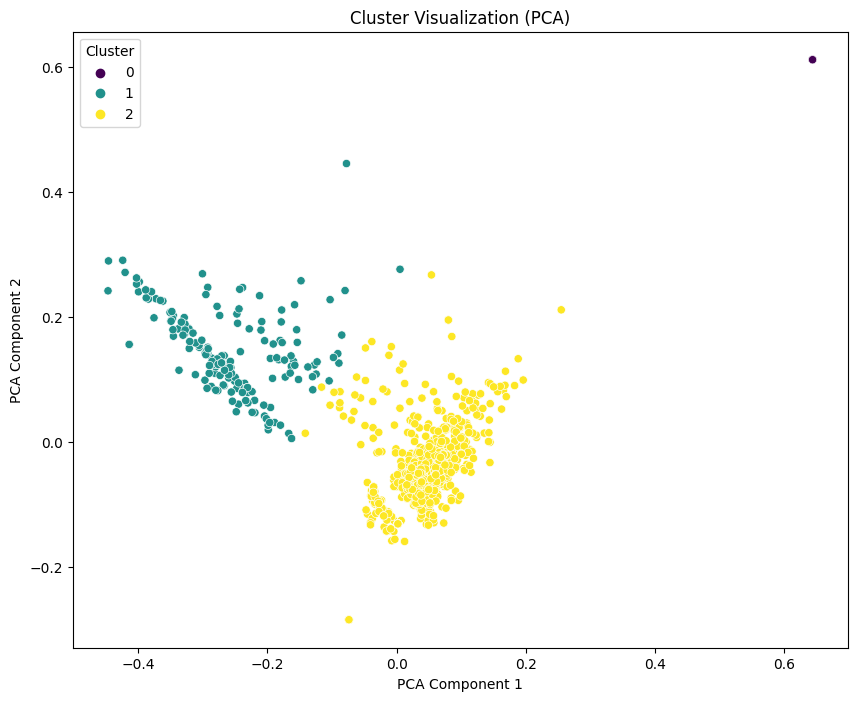

In [13]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization (e.g., using PCA)
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray()) # Convert sparse matrix to dense array

df['pca_x'] = pca_result[:, 0]
df['pca_y'] = pca_result[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='pca_x', y='pca_y', hue='cluster', palette='viridis')
plt.title('Cluster Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [14]:
# Install fasttext if you haven't already
!pip install fasttext==0.9.2

import fasttext

# Download the pre-trained language identification model
# This is a large file, so it might take some time
try:
    lid_model = fasttext.load_model('lid.176.bin')
except ValueError: # Handle case where model is not found locally
    print("Downloading fasttext language identification model...")
    import urllib.request
    url = 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
    urllib.request.urlretrieve(url, 'lid.176.bin')
    lid_model = fasttext.load_model('lid.176.bin')


def identify_language(text):
    """Identifies the language of a given text."""
    try:
        # Remove newline characters before processing
        text = text.replace('\n', ' ')
        result = lid_model.predict(text)
        language_label = result[0][0]
        language_code = language_label.replace('__label__', '')
        return language_code
    except Exception as e:
        print(f"Error identifying language for text: {text[:50]}... - {e}")
        return None

# Apply language identification to your DataFrame
df['language'] = df['text'].apply(identify_language)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp311-cp311-linux_x86_64.whl size=4304105 sha256=384c2ee98b3582d2cdc8fc9ae8381f1489f6c404a1dc6087d65782b64666848f
  Stored in directory: /root/.cache/pip/wheels/12/89/c9/c932d04c4dd65abe347bbb3e6f7668688753cbc585305ad8b7
Successfully built fasttext


Found 680 English posts out of 1000 total posts.


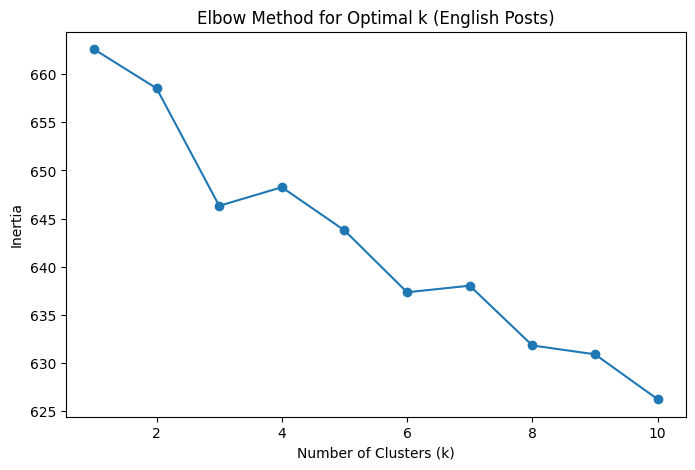


Top terms per cluster (English Posts):
Cluster 0:
 - ai
 - feed
 - detail
 - interest
 - data
 - post
 - futur
 - 2025
 - educ
 - school
--------------------
Cluster 1:
 - ai
 - use
 - human
 - one
 - say
 - get
 - gener
 - right
 - go
 - need
--------------------
Cluster 2:
 - make
 - ai
 - new
 - would
 - compani
 - use
 - browser
 - financi
 - servic
 - focus
--------------------
Cluster 3:
 - like
 - look
 - ai
 - see
 - im
 - cant
 - work
 - feel
 - peopl
 - use
--------------------
Cluster 4:
 - quantum
 - linkedin
 - frenchtech
 - socialmedia
 - tonymoroneybskysoci
 - bosch
 - web3
 - digitalhealth
 - bskyapp
 - enilevmom
--------------------
Cluster 5:
 - mhealth
 - industry40
 - iot
 - comment
 - healthtech
 - thought
 - guidanc
 - us
 - offic
 - copyright
--------------------

Sample posts from Cluster 0 (English Posts):
- All the sci-fi we’ve ever read just skipped over this part of the future – where AI exists, but peop...
- An old-school method of testing – the blue book 

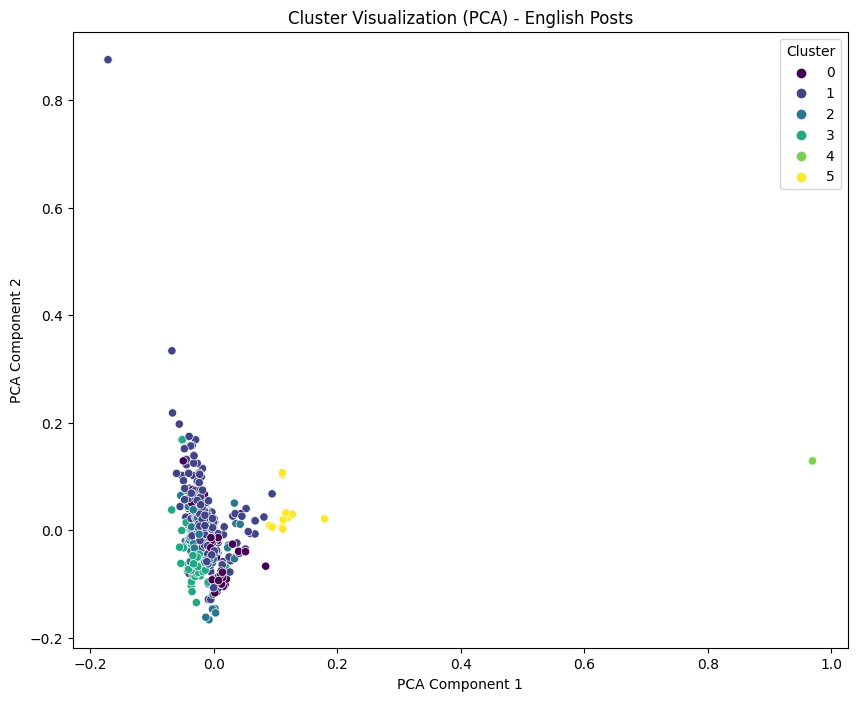

In [16]:
# prompt: Rerun the topic analysis just for English posts.

# Filter the DataFrame to include only English posts
english_df = df[df['language'] == 'en'].copy()

print(f"Found {len(english_df)} English posts out of {len(df)} total posts.")

# Check if there are any English posts to process
if len(english_df) == 0:
    print("No English posts found to perform topic analysis on.")
else:
    # --- Rerun Topic Analysis for English Posts ---

    # Apply preprocessing to the English post text
    english_df['processed_text'] = english_df['text'].apply(preprocess_text)

    # Create TF-IDF vectors specifically for English posts
    tfidf_vectorizer_en = TfidfVectorizer(max_features=1000)
    tfidf_matrix_en = tfidf_vectorizer_en.fit_transform(english_df['processed_text'])

    # Determine the optimal number of clusters for English posts (using Elbow Method)
    inertia_en = []
    for i in range(1, 11):
        kmeans_en = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans_en.fit(tfidf_matrix_en)
        inertia_en.append(kmeans_en.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), inertia_en, marker='o')
    plt.title('Elbow Method for Optimal k (English Posts)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

    # Choose a suitable number of clusters for English posts (adjust based on the plot)
    num_clusters_en = 6 # You can adjust this based on the English Elbow Method plot

    # Apply K-Means clustering to English posts
    kmeans_en = KMeans(n_clusters=num_clusters_en, random_state=42, n_init=10)
    english_df['cluster'] = kmeans_en.fit_predict(tfidf_matrix_en)

    # Get the terms for each cluster of English posts
    order_centroids_en = kmeans_en.cluster_centers_.argsort()[:, ::-1]
    terms_en = tfidf_vectorizer_en.get_feature_names_out()

    print("\nTop terms per cluster (English Posts):")
    for i in range(num_clusters_en):
        print(f"Cluster {i}:")
        for ind in order_centroids_en[i, :10]: # Print top 10 terms per cluster
            print(f" - {terms_en[ind]}")
        print("-" * 20)

    # View sample posts within each cluster for English posts
    for cluster_id in range(num_clusters_en):
        print(f"\nSample posts from Cluster {cluster_id} (English Posts):")
        cluster_posts_en = english_df[english_df['cluster'] == cluster_id]['text'].sample(min(5, len(english_df[english_df['cluster'] == cluster_id])))
        for post_text in cluster_posts_en:
            print(f"- {post_text[:100]}...")
        print("-" * 20)

    # Reduce dimensions for visualization (PCA) for English posts
    pca_en = PCA(n_components=2, random_state=42)
    pca_result_en = pca_en.fit_transform(tfidf_matrix_en.toarray())

    english_df['pca_x'] = pca_result_en[:, 0]
    english_df['pca_y'] = pca_result_en[:, 1]

    # Visualize the clusters for English posts
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=english_df, x='pca_x', y='pca_y', hue='cluster', palette='viridis')
    plt.title('Cluster Visualization (PCA) - English Posts')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()


Cluster Analysis:

--- Cluster 0 ---
Sentiment Distribution:
Positive    46
Neutral     20
Negative    15
Name: sentiment_category, dtype: int64
Average Compound Sentiment: 0.20

Top Terms:
ai, feed, detail, interest, data, post, futur, 2025, educ, school

Number of posts in this cluster: 81


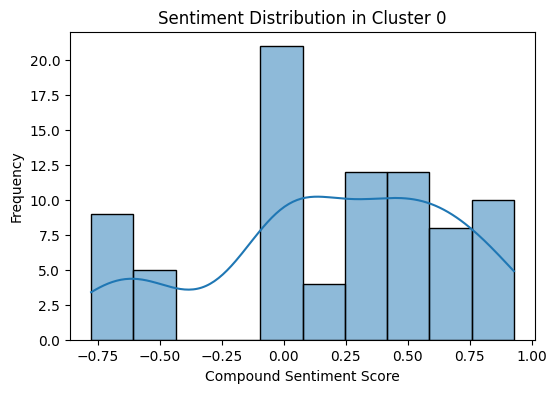


--- Cluster 1 ---
Sentiment Distribution:
Positive    156
Negative    121
Neutral      93
Name: sentiment_category, dtype: int64
Average Compound Sentiment: 0.05

Top Terms:
ai, use, human, one, say, get, gener, right, go, need

Number of posts in this cluster: 370


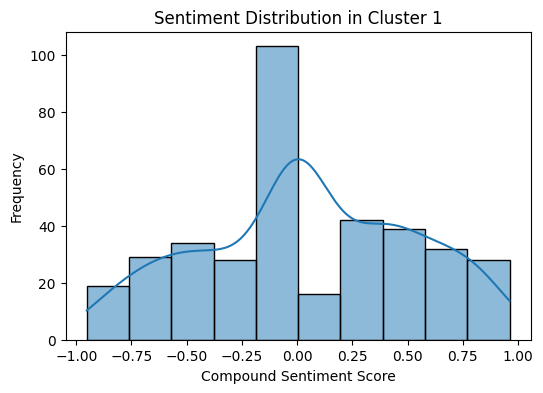


--- Cluster 2 ---
Sentiment Distribution:
Positive    41
Negative    32
Neutral     30
Name: sentiment_category, dtype: int64
Average Compound Sentiment: 0.03

Top Terms:
make, ai, new, would, compani, use, browser, financi, servic, focus

Number of posts in this cluster: 103


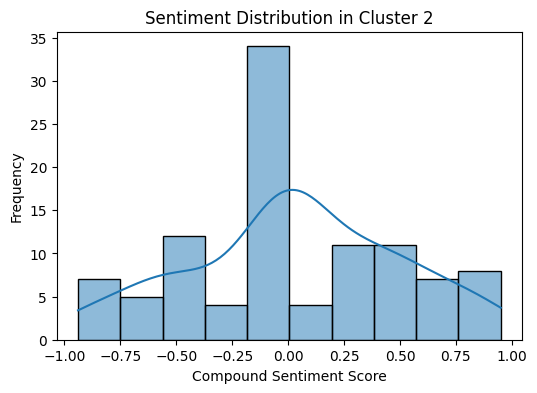


--- Cluster 3 ---
Sentiment Distribution:
Positive    56
Negative    35
Neutral      9
Name: sentiment_category, dtype: int64
Average Compound Sentiment: 0.13

Top Terms:
like, look, ai, see, im, cant, work, feel, peopl, use

Number of posts in this cluster: 100


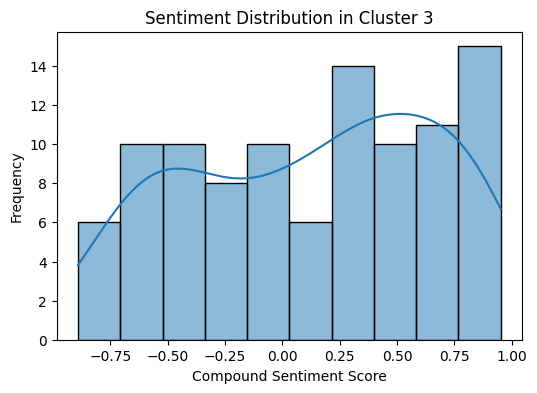


--- Cluster 4 ---
Sentiment Distribution:
Neutral    10
Name: sentiment_category, dtype: int64
Average Compound Sentiment: 0.00

Top Terms:
quantum, linkedin, frenchtech, socialmedia, tonymoroneybskysoci, bosch, web3, digitalhealth, bskyapp, enilevmom

Number of posts in this cluster: 10


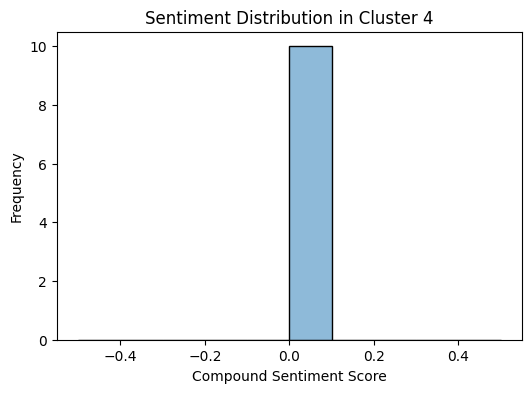


--- Cluster 5 ---
Sentiment Distribution:
Neutral     11
Positive     4
Negative     1
Name: sentiment_category, dtype: int64
Average Compound Sentiment: 0.12

Top Terms:
mhealth, industry40, iot, comment, healthtech, thought, guidanc, us, offic, copyright

Number of posts in this cluster: 16


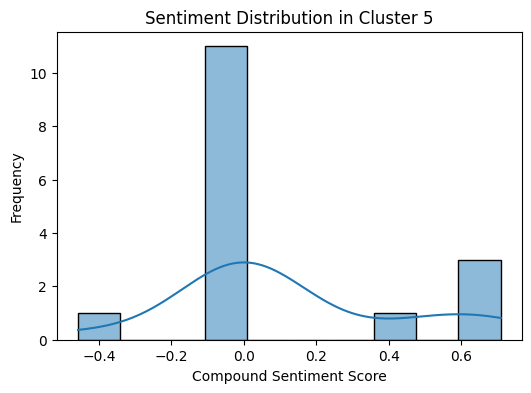

In [17]:
# prompt: Provide an analysis of each cluster, including sentiment and other related aspects.

print("\nCluster Analysis:")
for i in range(num_clusters_en):
    cluster_df = english_df[english_df['cluster'] == i]
    print(f"\n--- Cluster {i} ---")

    # Sentiment Analysis for the cluster
    print("Sentiment Distribution:")
    print(cluster_df['sentiment_category'].value_counts())
    print(f"Average Compound Sentiment: {cluster_df['compound_sentiment'].mean():.2f}")

    # Top terms for the cluster (already printed, but can be summarized)
    print("\nTop Terms:")
    top_terms_indices = order_centroids_en[i, :10]
    top_terms = [terms_en[ind] for ind in top_terms_indices]
    print(", ".join(top_terms))

    # Other potential analyses:
    # - Time distribution of posts in the cluster (earlier/later posts)
    # - Count of posts per day in the cluster
    # - Sample posts (already printed, but useful for qualitative analysis)

    # Example: Count of posts in this cluster
    print(f"\nNumber of posts in this cluster: {len(cluster_df)}")

    # Example: Average sentiment score distribution within the cluster
    plt.figure(figsize=(6, 4))
    sns.histplot(cluster_df['compound_sentiment'], bins=10, kde=True)
    plt.title(f'Sentiment Distribution in Cluster {i}')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()